# Finding the Tennis Suspects

This is the data analysis source code accompanying [Finding the Tennis Suspects](https://medium.com/p/c2d9f198c33d). This notebook is a heavily modified version of the notebook released by BuzzFeed in its [original data analyis](https://github.com/BuzzFeedNews/2016-01-tennis-betting-analysis/blob/master/notebooks/tennis-analysis.ipynb).

In [19]:
import math
import numpy as np
import pandas as pd
import datetime
from collections import Counter
from collections import defaultdict
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window. Credit to cs231n.stanford.edu for this snippet.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## Importing BuzzFeed's Data

In [20]:
buzzfeed_data = pd.read_csv("../data/anonymous_betting_data.csv")
print "Number of rows in BuzzFeed's anonymized dataset:", len(buzzfeed_data)

Number of rows in BuzzFeed's anonymized dataset: 129271


## Importing Our Scraped Data from OddsPortal.com

We scraped 2009-2015 odds data from several different bookmakers on OddsPortal.com, the same source BuzzFeed used in their analysis. Our scraping was not exhaustive, but the amount of data we collected is sufficient for deanonymization.

In [21]:
# Read in our (non-anonymous) OddsPortal data
op_data = pd.read_json('../data/op_data.json')
print "Number of rows in our dataset:", len(op_data)

Number of rows in our dataset: 26057


### Removing different notation

We scraped odds data from OddsPortal.com from years 2009-2015, just like BuzzFeed. OddsPortal.com generally gave us back data in decimal notation (the same notation that BuzzFeed uses), but sometimes we got results in American notation instead. To be consistent with BuzzFeed and keep our data as unambiguous as possible, we filter out all of our data that uses American odds notation.

N.B. We could have also just converted to decimal notation, but a) we have enough data that we didn't need to, and b) we didn't want to risk subtle floating point equality errors.

In [22]:
# Filter our American odds notation in the dataset

# Step 1. Filter out rows with internally inconsistent notation
def is_notationally_consistent(row):
    """While scraping OddsPortal, we sometimes got results in decimal odds notation and sometimes in American.
       If a single row is internally inconsistent, we will use this function to throw it out to be safe."""
    winner_is_american_notation = abs(row['odds_winner_open']) >= 100.0 and abs(row['odds_winner_close']) >= 100.0
    loser_is_american_notation = abs(row['odds_loser_open']) >= 100.0 and abs(row['odds_loser_close']) >= 100.0
    return winner_is_american_notation == loser_is_american_notation

row_internally_consistent_op_data = op_data[op_data.apply(is_notationally_consistent, axis=1)]
print '{} rows with internally inconsistent notation removed out of {}'.format(len(op_data) - len(row_internally_consistent_op_data), len(op_data))

70 rows with internally inconsistent notation removed out of 26057


In [23]:
# Step 2: Filter out rows that use American notation

def is_american_notation(row):
    winner_is_american_notation = abs(row['odds_winner_open']) >= 100.0 and abs(row['odds_winner_close']) >= 100.0
    loser_is_american_notation = abs(row['odds_loser_open']) >= 100.0 and abs(row['odds_loser_close']) >= 100.0
    
    # The last step should have already filtered out internally inconsistent notation
    assert winner_is_american_notation == loser_is_american_notation
    
    return winner_is_american_notation and loser_is_american_notation

decimal_op_data = row_internally_consistent_op_data[
    row_internally_consistent_op_data.apply(lambda row: not is_american_notation(row), axis=1)
]

print '{} rows with American notation removed out of {}'.format(
    len(row_internally_consistent_op_data) - len(decimal_op_data), len(row_internally_consistent_op_data))

print '{} rows remaining'.format(len(decimal_op_data))

7598 rows with American notation removed out of 25987
18389 rows remaining


## Utilities

In [24]:
def extract_tuple(row, include_book=False):
    """Get the values from the row of the fields that we will eventually join on"""
    if include_book:
        return (
            row['book'],
            row['odds_winner_open'],
            row['odds_loser_open'],
            row['odds_winner_close'],
            row['odds_loser_close'],
            row['year'],
            row['is_cancelled_or_walkover'],
        )
    else:
        return (
            row['odds_winner_open'],
            row['odds_loser_open'],
            row['odds_winner_close'],
            row['odds_loser_close'],
            row['year'],
            row['is_cancelled_or_walkover'],
        )

In [25]:
def graph_counter(c):
    """Draw a bar graph of a Counter"""
    labels, values = zip(*c.items())

    indexes = np.arange(len(labels))
    width = 1

    plt.bar(indexes, values, width)
    plt.xticks(indexes + width * 0.5, labels)
    plt.show()

## Part 1: Deanonymizing the Bookmakers

BuzzFeed used odds from seven large, independent bookmakers whose odds are available on OddsPortal.com for their analysis. However, they didn't specify which seven bookmakers they used. Instead, they use the letters A through G to refer to these different bookmakers anonymously in their dataset.

To cross-match BuzzFeed's data with the data we scraped from OddsPortal.com ourselves, we first need to deanonymize the bookmakers. This allows us to make sure we only consider the same bookmakers that BuzzFeed does when we search for player names later.

### Step 1: Getting rid of ambiguous data
Eventually, we will deanonymize BuzzFeed's data by finding which BuzzFeed data entries uniquely match our own (named) data entries. We know right off the bat that the following field values are shared across both datasets:

***('odds_winner_open', 'odds_winner_close', 'odds_loser_open', 'odds_loser_close', 'year', 'is_cancelled_or_walkover')***

So, right away we can associate data from BuzzFeed with our own data, by finding when these six values are identical.

However, we won't be able to make an exact match to our own data if there are multiple data entries from BuzzFeed that share the same values for all the fields above. We want to be as confident as possible in our results, so our first step is to remove all of the ambiguous data from BuzzFeed: data where the same set of values for these six fields occurs more than once.

In [26]:
values = []
for i, row in buzzfeed_data.iterrows():
    values.append(extract_tuple(row))

c = Counter(values)
bf_uniques = set([x for x in values if c[x] == 1])

def is_bf_unique(row):
    """True if the relevant tuple is unique among all rows in the BuzzFeed dataset."""
    return extract_tuple(row) in bf_uniques

bf_filtered = buzzfeed_data[buzzfeed_data.apply(is_bf_unique, axis=1)]
before = len(buzzfeed_data)
after = len(bf_filtered)

print 'Removed {} ambiguous rows from BuzzFeed\'s dataset'.format(before - after)
print '{} rows remaining'.format(after)

Removed 58907 ambiguous rows from BuzzFeed's dataset
70364 rows remaining


We also want to remove ambiguous data from our dataset.

In [27]:
values = []
for i, row in decimal_op_data.iterrows():
    values.append(extract_tuple(row))

c = Counter(values)
decimal_op_uniques = set([x for x in values if c[x] == 1])
unique_decimal_op_data = decimal_op_data[
    decimal_op_data.apply(lambda row: extract_tuple(row) in decimal_op_uniques, axis=1)
]

before = len(decimal_op_data)
after = len(unique_decimal_op_data)

print 'Removed {} ambiguous rows from our dataset'.format(before - after)
print '{} rows remaining'.format(after)

Removed 7553 ambiguous rows from our dataset
10836 rows remaining


### Step 2: Combining matching data from the two datasets

We're now ready to join the two tables together, using the shared fields mentioned before.

In [28]:
# Join the two!
MERGE_HEADERS = [
    'odds_winner_open',
    'odds_loser_open',
    'odds_winner_close',
    'odds_loser_close',
    'year',
    'is_cancelled_or_walkover',
]

merged = pd.merge(bf_filtered, unique_decimal_op_data, how='inner', on=MERGE_HEADERS)
print 'Found {} matching entries between BuzzFeed\'s dataset and ours'.format(len(merged))


Found 2844 matching entries between BuzzFeed's dataset and ours


### Step 3: Map BuzzFeed's anonymized letters to the real names of bookmakers

Our goal here is to deanonymize at least some of the bookmakers. This way, we can make sure to
exclude all data in our own OddsPortal dataset that didn't come from a bookmaker we are confident
BuzzFeed used. Without this step there would be a (small, but non-zero) risk of false positives when we later
deanonymize the player names: we might match a row in BuzzFeed's anonymized data to a row in
ours from a bookmaker that BuzzFeed never even used.

In [29]:
letter_to_book = defaultdict(lambda: Counter())
for i, row in merged.iterrows():
    letter, book_name = row['book_x'], row['book_y']
    letter_to_book[letter].update([book_name])

def get_deanonymized_book_if_confident(c):
    top_2 = c.most_common(min(2, len(c)))
    _, counts = zip(*c.items())
    if sum(counts) < 100:
        # Not enough data
        return None
    
    if len(top_2) == 1:
        # We are confident -- no alternative bookmakers found for this letter
        return top_2[0][0]
    else:
        best_count, second_best_count = top_2[0][1], top_2[1][1]
        if 1.0 * second_best_count / best_count < .05:
            # We are confident -- best guest occurs at least 20x as frequently as second best guess
            return top_2[0][0]
    return None

deanonymized_books = {}

print 'Deanonymized bookmakers:'
for key in letter_to_book:
    bookmaker = get_deanonymized_book_if_confident(letter_to_book[key])
    if bookmaker:
        deanonymized_books[key] = bookmaker
        print '{}: {}'.format(key, bookmaker)
    else:
        print '{}: [Uncertain]'.format(key)

Deanonymized bookmakers:
A: bet365
C: Pinnacle Sports
B: bwin
E: [Uncertain]
D: Unibet
G: [Uncertain]
F: [Uncertain]


Key: A


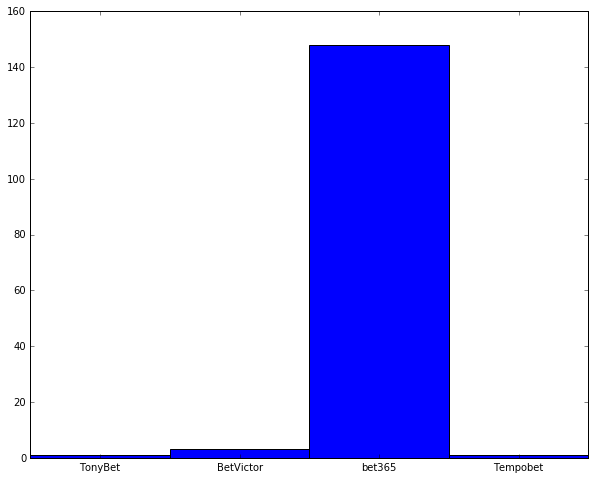

Key: C


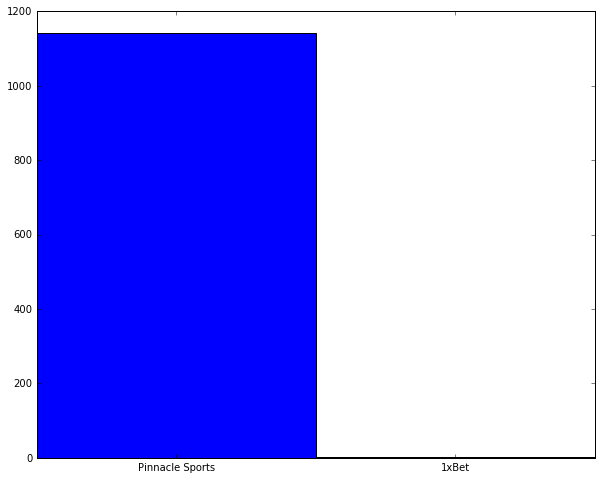

Key: B


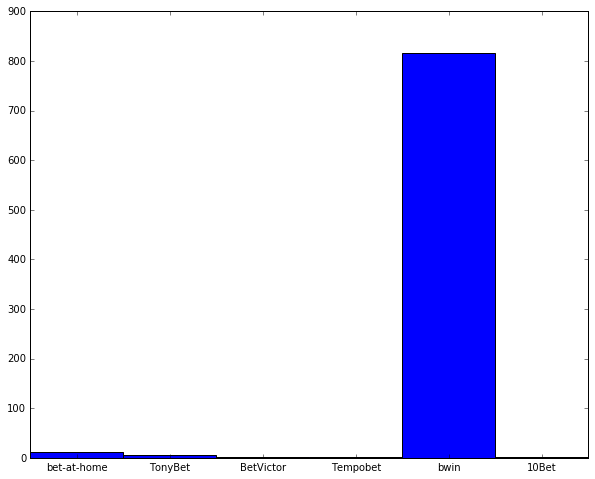

Key: D


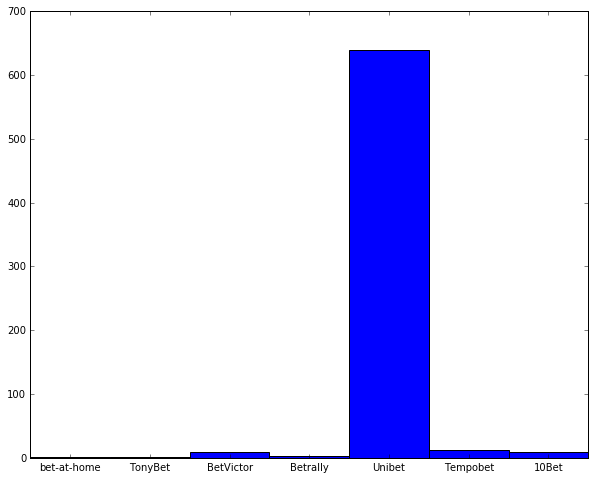

In [30]:
# Visualize our confidence about the deanonymized bookmakers.

for key in letter_to_book:
    if key in deanonymized_books:
        print 'Key:', key
        graph_counter(letter_to_book[key])

In [31]:
# Now that we've deanonymized some bookmakers, we will only use odds from those bookmakers
# when cross-referencing BuzzFeed's dataset with our OddsPortal dataset. This way we can
# have confidence that our dataset is a subset of BuzzFeed's.

known_bookmakers = deanonymized_books.values()

decimal_op_data_with_known_books = decimal_op_data[
    decimal_op_data.apply(lambda row: row['book'] in known_bookmakers, axis=1)
]

print 'Size of our OddsPortal dataset with only deanonymized bookmakers:\n{}'.format(
    len(decimal_op_data_with_known_books)
)

Size of our OddsPortal dataset with only deanonymized bookmakers:
9187


In [32]:
# Once again, we filter out all non-unique rows in our OddsPortal dataset. This time
# our criteria for what makes a row "unique" is more detailed, because we also look
# at the bookmaker (now that bookmakers are deanonymized).

# Get the set of unique rows
values = []
for i, row in decimal_op_data_with_known_books.iterrows():
    values.append(extract_tuple(row, include_book=True))

c = Counter(values)
uniqs = set([x for x in values if c[x] == 1])

final_op_data = decimal_op_data_with_known_books[
    decimal_op_data_with_known_books.apply(lambda row: extract_tuple(row, include_book=True) in uniqs, axis=1)
]

before = len(decimal_op_data_with_known_books)
after = len(final_op_data)

print 'After filtering, our dataset has {} rows'.format(after)

After filtering, our dataset has 5645 rows


In [33]:
# Our next step is to filter BuzzFeed's dataset to include only rows with known bookmakers,
# and to replace BuzzFeed's anonymized lettering scheme with the known names.

known_books_filtered_bd = bf_filtered[
    bf_filtered.apply(lambda row: row['book'] in deanonymized_books, axis=1)
]

named_books_filtered_bd = known_books_filtered_bd.copy()
named_books_filtered_bd['book'] = named_books_filtered_bd['book'].apply(lambda x: deanonymized_books[x])

In [34]:
# We now merge the BuzzFeed data and our data, merging on the bookmaker column in addition to
# the previous ones.

MERGE_HEADERS_WITH_BOOK = [
    'book',
    'odds_winner_open',
    'odds_loser_open',
    'odds_winner_close',
    'odds_loser_close',
    'year',
    'is_cancelled_or_walkover',
]

merged_with_book = pd.merge(named_books_filtered_bd, final_op_data, how='inner', on=MERGE_HEADERS_WITH_BOOK)
len(merged_with_book)

2757

In [35]:
# The anonymized names of the 15 players BuzzFeed found in its data analysis
# See the table in which they published these hashes at:
# https://github.com/BuzzFeedNews/2016-01-tennis-betting-analysis/blob/master/notebooks/tennis-analysis.ipynb

suspect_hashes = ['f16cc81d239ad735c51cc71442cda44c4d1a9323eb41018314d228c80c352e50',
'33367d214715ab5f5e335cd67dbc90e62983b98e5278a4eadf39c3a18124509e',
'6702a5de750846f45a3d977f50023c1b20156c61949f2f407b9c5b71d7d93a18',
'9c92af8ca1b57024bd0a39b73db8be44b25bcde4115549cd80e7ef15fc3bd516',
'0ffe23c8b80916f6b2c23a52e08018374d68d12f49b261ccb36fecd52927cc0a',
'05f3190e5053090035664800d1f52203b40a826cf7f06534bfe153492174f504',
'573dad2e08250afa99aa704c7ea888b421bcf06bd00aab8df3997fe64ee2df64',
'dd83d749567ad7c7f4e89656b08d4791acefd60724cc848697903d2aa13731c7',
'79784720fab57e7cc611e07c258cf49f484b9cee01bf47639431e8c4def3f0d4',
'4f7f8e1b43947b2fb123afb92263b4a863daa87a4de44cabe94e7cb4df8fa1ae',
'822130a3121c663ea88c6429830f23a794791fed013f6ec521b2e562a95fd657',
'5e77273d54e1ce9635dc4c3d0ab9f872ba3cf4f7d1204c3c94e1e396475e066f',
'163a93c4de594ac23ebc52c7ae413761ea412054eec4b4eb486ceaaf78818e6a',
'afd6124804065e4ba90270b3307940c404c2f286180009ba3fb2d4723b5b76e6',
'178a5dbb14af3102f863f493fc909bcca7b116f991fa6940d05d59eb96b0447a',]

In [36]:
# Deanonymize players

hash_to_player = defaultdict(lambda: Counter())
for i, row in merged_with_book.iterrows():
    h_loser, h_winner = row['loser_x'], row['winner_x']
    name_loser, name_winner = row['loser_y'], row['winner_y']
    hash_to_player[h_loser].update([name_loser])
    hash_to_player[h_winner].update([name_winner])

found_hashes = hash_to_player.keys() 
for h in suspect_hashes:
    if h not in found_hashes:
        print 'NOT FOUND'
        continue

    counts = hash_to_player[h]
    candidate, candidate_quantity = counts.most_common(1)[0]
    total = sum(counts.values())
    
    print '{}: {}, match rate = {}% ({}/{} instances)'.format(
        h, candidate, candidate_quantity * 100.0 / total, candidate_quantity, total)

f16cc81d239ad735c51cc71442cda44c4d1a9323eb41018314d228c80c352e50: Andreev I., match rate = 100.0% (36/36 instances)
33367d214715ab5f5e335cd67dbc90e62983b98e5278a4eadf39c3a18124509e: Lacko L., match rate = 100.0% (15/15 instances)
6702a5de750846f45a3d977f50023c1b20156c61949f2f407b9c5b71d7d93a18: Dodig I., match rate = 100.0% (47/47 instances)
9c92af8ca1b57024bd0a39b73db8be44b25bcde4115549cd80e7ef15fc3bd516: Golubev A., match rate = 100.0% (16/16 instances)
0ffe23c8b80916f6b2c23a52e08018374d68d12f49b261ccb36fecd52927cc0a: Chela J. I., match rate = 100.0% (20/20 instances)
05f3190e5053090035664800d1f52203b40a826cf7f06534bfe153492174f504: Hewitt L., match rate = 100.0% (33/33 instances)
573dad2e08250afa99aa704c7ea888b421bcf06bd00aab8df3997fe64ee2df64: Hajek J., match rate = 100.0% (18/18 instances)
dd83d749567ad7c7f4e89656b08d4791acefd60724cc848697903d2aa13731c7: Montanes A., match rate = 100.0% (35/35 instances)
79784720fab57e7cc611e07c258cf49f484b9cee01bf47639431e8c4def3f0d4: Gimeno-Trav

---

---

---